# Digital Marketing Optimization - Google Store

[![Open in Deepnote](https://deepnote.com/buttons/launch-in-deepnote.svg)](https://deepnote.com/workspace/PolData-40264208-503b-448c-a998-f4e7dbcd20de/project/Digital-Marketing-Optimization-4f991c85-a4f1-4651-91c2-0876d552a54d/notebook/Notebook-9c37f2feab6546e8aa92af9dbbd3eeaa?utm_source=share-modal&utm_medium=product-shared-content&utm_campaign=notebook&utm_content=4f991c85-a4f1-4651-91c2-0876d552a54d)

![Project Banner](https://img.shields.io/badge/Status-Complete-success) ![Python](https://img.shields.io/badge/Python-3.11-blue)

In [1]:
import pandas as pd
import duckdb
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV files for October, November, and December and force data type change to text for two fields to avoid integrity issue with large number

data_oct = pd.read_csv('/work/Data/10_data_oct.csv', dtype={'fullvisitorid': str, 'visitid': str})
data_nov = pd.read_csv('/work/Data/11_data_nov.csv', dtype={'fullvisitorid': str, 'visitid': str})
data_dec = pd.read_csv('/work/Data/12_data_dec.csv', dtype={'fullvisitorid': str, 'visitid': str})


In [2]:
# combine the three dataframes into one dataframe with a new fresh index to avoid duplicated index conflicts
data_combined = pd.concat([data_oct, data_nov, data_dec], ignore_index=True)

# rename the `transactionrevenu` column
data_combined.rename(columns={'transactionrevenu': 'transactionrevenue'}, inplace=True)

## Preview of the Combined Dataset

In [3]:
data_combined = _dntk.execute_sql(
  'SELECT * FROM data_combined;',
  'SQL_DEEPNOTE_DATAFRAME_SQL',
  audit_sql_comment='',
  sql_cache_mode='cache_disabled',
  return_variable_type='dataframe'
)
data_combined

,fullvisitorid,visitid,date,channelGrouping,visits,pageviews,timeonsite,bounces,transactions,transactionrevenue,...,source,medium,adcontent,operatingSystem,isMobile,deviceCategory,region,country,continent,subcontinent
0,2396261837367755622,1476002073,1476002073,Organic Search,1,0,0,0,0,0,...,(direct),(none),None,Windows,False,desktop,None,United States,Americas,Northern America
1,9220188228700966316,1476783975,1476783975,Organic Search,1,0,9,0,0,0,...,google,organic,None,Macintosh,False,desktop,None,United States,Americas,Northern America
2,5617770153245303309,1476907903,1476907903,Referral,1,0,399,0,0,0,...,(direct),(none),None,Macintosh,False,desktop,California,United States,Americas,Northern America
3,1148523789374750492,1476542990,1476542990,Affiliates,1,1,0,1,0,0,...,Partners,affiliate,None,iOS,True,mobile,None,United States,Americas,Northern America
4,4738724999108522154,1477262558,1477262558,Direct,1,1,0,1,0,0,...,(direct),(none),None,iOS,True,mobile,California,United States,Americas,Northern America
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99096,081985686030532619,1481306198,1481306198,Direct,1,143,2363,0,1,346620000,...,(direct),(none),None,Windows,False,desktop,None,United States,Americas,Northern America
99097,5058196910159976870,1483021729,1483021729,Direct,1,145,1935,0,0,0,...,(direct),(none),None,Chrome OS,False,desktop,New York,United States,Americas,Northern America
99098,5037208788065339806,1481587574,1481587574,Referral,1,149,9275,0,2,681400000,...,sites.google.com,referral,None,Macintosh,False,desktop,California,United States,Americas,Northern America
99099,3047413202770064139,1482872974,1482872974,Social,1,190,3579,0,0,0,...,youtube.com,referral,None,Linux,False,desktop,None,United States,Americas,Northern America


# Situation
### Business Questions

- How do users interact with our e-commerce platform? Are there specific user behaviors or patterns that can inform our marketing strategies?
- How effective are our promotional campaigns and discount strategies in driving sales? Do these initiatives lead to long-term customer retention or only short-term gains?
- How does the user experience on our website and mobile app impact sales and customer engagement? Are there areas in need of improvement?
- Which geographical markets or customer segments are most profitable? Are there emerging markets or segments that we should focus on?
- How effective are our current strategies in acquiring new customers and retaining existing ones?
- Which traffic channels are yielding the highest conversion rates? What are the underlying reasons for variations in conversion rates across different channels?

# Data Exploration

The _data grain_ should uniquely identify a single visit to the merchandise store.  

The dataset has a total of `99,101` rows.  
The number of unique `fullvisitorid` is `70,037`.  
The number of unique `visitid` is `98,129`.  

This suggests that there are duplicated values in both fields. 


In [4]:
query_2 = _dntk.execute_sql(
  'SELECT \n    COUNT(*) n_rows, \n    COUNT(DISTINCT fullvisitorid) n_fullvisitorid, \n    COUNT(DISTINCT visitid) n_visitid,\n    COUNT(DISTINCT (fullvisitorid, visitid)) n_fullvisitorid_visitid\nFROM data_combined;\n',
  'SQL_DEEPNOTE_DATAFRAME_SQL',
  audit_sql_comment='',
  sql_cache_mode='cache_disabled',
  return_variable_type='query_preview'
)
query_2

,n_rows,n_fullvisitorid,n_visitid,n_fullvisitorid_visitid
0,99101,70037,98129,99099


## Data Grain

The data grain `fullvisitorid` + `visitid` returns two duplicated records.
I will investigate if these are actual duplicates or whether there are other reasons for them to exist.

In [5]:
query_3 = _dntk.execute_sql(
  'SELECT *\nFROM data_combined\nWHERE fullvisitorid IN (\n    SELECT fullvisitorid \n    FROM data_combined\n    GROUP BY fullvisitorid, visitid\n    HAVING COUNT(*) > 1);',
  'SQL_DEEPNOTE_DATAFRAME_SQL',
  audit_sql_comment='',
  sql_cache_mode='cache_disabled',
  return_variable_type='query_preview'
)
query_3

,fullvisitorid,visitid,date,channelGrouping,visits,pageviews,timeonsite,bounces,transactions,transactionrevenue,...,source,medium,adcontent,operatingSystem,isMobile,deviceCategory,region,country,continent,subcontinent
0,0368176022600320212,1477983528,1477983528,Referral,1,6,68,0,0,0,...,(direct),(none),None,Linux,False,desktop,California,United States,Americas,Northern America
1,0368176022600320212,1477983528,1477983600,Referral,1,3,75,0,0,0,...,(direct),(none),None,Linux,False,desktop,California,United States,Americas,Northern America
2,4961200072408009421,1480578925,1480578925,Referral,1,15,270,0,0,0,...,(direct),(none),None,Macintosh,False,desktop,California,United States,Americas,Northern America
3,4961200072408009421,1480578925,1480579217,Referral,1,2,15,0,0,0,...,(direct),(none),None,Macintosh,False,desktop,California,United States,Americas,Northern America


After closely observing these duplicated records, it seems they are part of the same session that got split between two different dates, suggesting that the google analytics software created a new session record after midnight has passed.

The only fields that seem affected are `pageviews` and `timeonsite`.

I will look into the `date` field to better understand if that is the case. Given that this dataset is related to the US market, I will safely assume that the data was recorded based on the _Pacific Time_ in the _USA_, which is where Google is headquartered.

In [6]:
query_4 = _dntk.execute_sql(
  'SELECT\n    fullvisitorid, visitid, to_timestamp(date) AS session_timestamp\nFROM data_combined \nWHERE fullvisitorid IN (\n    SELECT fullvisitorid \n    FROM data_combined\n    GROUP BY fullvisitorid, visitid\n    HAVING COUNT(*) > 1);',
  'SQL_DEEPNOTE_DATAFRAME_SQL',
  audit_sql_comment='',
  sql_cache_mode='cache_disabled',
  return_variable_type='query_preview'
)
query_4

,fullvisitorid,visitid,session_timestamp
0,0368176022600320212,1477983528,2016-11-01 06:58:48+00:00
1,0368176022600320212,1477983528,2016-11-01 07:00:00+00:00
2,4961200072408009421,1480578925,2016-12-01 07:55:25+00:00
3,4961200072408009421,1480578925,2016-12-01 08:00:17+00:00


## Data Integrity Challenge: Diagnosing and Resolving the Daylight/Standard Time Issue
After converting the `date` to a timestamp I noticed, based on the dates, that the first duplicated session is in the _Pacifici Daylight Time (PDT)_ that is (UTC-7) while the second duplicated session is in the _Pacific Standard Time_ that is (UTC-8).

This quickly explain at a glance why we have these duplicates: The session started before midnight of that day, and ended after midnight, making the software to shift to the next day therefore recording a new (duplicated in this case) session.

We can safely then treat the composition of `fullvisitorid` and `visitid` as our __data grain__ or __primary key__.

### Solution

With this new insight, to remove such duplicates I will adopt the following strategy:

- I will GROUP BY the `fullvisitorid` and `visitid` to create a unique identifier
- For the session start date I will consider the `MIN(date_column)` to anchor the entire session to the actual date/hour it began which will fix the midnight split.
- For `pageviews` and `timeonsite` I will `SUM()` the values to capture the total activity from both split sessions.
- For `transactions` and `transactionrevenue` I will keep only the `MAX()` value, to prevent double-counting revenue in the case that it was logged on both split rows. If only one row contains the revenue, `MAX()` safely captures it. This forward looking approach, in case future data will get recorded and added. For this dataset in these two duplicated sessions there was no monetization recorded (values are 0).

#### Timestamps

- I will convert the raw UNIX timestamps to Pacific Time (PST/PDT), accounting for the Daylight Saving Time shift on Nov 6th to ensure session time aligns with local business hours.

In [7]:
data_cleaned = _dntk.execute_sql(
  '-- prepare a cleaned dataset\nSELECT \n    CONCAT(fullvisitorid, visitid) AS session_id,\n    ANY_VALUE(fullvisitorid) AS fullvisitorid,\n    ANY_VALUE(visitid) AS visitid,\n    -- adjust time to the PDT and PST based on the date\n    MIN(\n        IF(\n            to_timestamp(date) < \'2016-11-06\', \n            to_timestamp(date) - INTERVAL 7 HOURS, \n            to_timestamp(date) - INTERVAL 8 HOURS)) AS start_date,\n    ANY_VALUE(channelGrouping) AS channelGrouping,\n    ANY_VALUE(visits) AS visits,\n    SUM(pageviews) AS pageviews,\n    SUM(timeonsite) AS timeonsite,\n    ANY_VALUE(bounces) AS bounces,\n    MAX(transactions) AS transactions,\n    MAX(transactionrevenue) AS transactionrevenue,\n    ANY_VALUE(newvisits) AS newvisits,\n    ANY_VALUE(timeonscreen) AS timeonscreen,\n    ANY_VALUE(sessionqualitydim) AS sessionqualitydim,\n    ANY_VALUE(source) AS source,\n    ANY_VALUE(medium) AS medium,\n    ANY_VALUE(adcontent) AS adcontent,\n    ANY_VALUE(operatingSystem) AS operatingSystem,\n    ANY_VALUE(isMobile) AS isMobile,\n    ANY_VALUE(deviceCategory) AS deviceCategory,\n    ANY_VALUE(region) AS region,\n    ANY_VALUE(country) AS country,\n    ANY_VALUE(continent) AS continent,\n    ANY_VALUE(subcontinent) AS subcontinent\nFROM data_combined\nGROUP BY 1;',
  'SQL_DEEPNOTE_DATAFRAME_SQL',
  audit_sql_comment='',
  sql_cache_mode='cache_disabled',
  return_variable_type='dataframe'
)
data_cleaned

,session_id,fullvisitorid,visitid,start_date,channelGrouping,visits,pageviews,timeonsite,bounces,transactions,...,source,medium,adcontent,operatingSystem,isMobile,deviceCategory,region,country,continent,subcontinent
0,23962618373677556221476002073,2396261837367755622,1476002073,2016-10-09 01:34:33+00:00,Organic Search,1,0.0,0.0,0,0,...,(direct),(none),None,Windows,False,desktop,None,United States,Americas,Northern America
1,92201882287009663161476783975,9220188228700966316,1476783975,2016-10-18 02:46:15+00:00,Organic Search,1,0.0,9.0,0,0,...,google,organic,None,Macintosh,False,desktop,None,United States,Americas,Northern America
2,56177701532453033091476907903,5617770153245303309,1476907903,2016-10-19 13:11:43+00:00,Referral,1,0.0,399.0,0,0,...,(direct),(none),None,Macintosh,False,desktop,California,United States,Americas,Northern America
3,11485237893747504921476542990,1148523789374750492,1476542990,2016-10-15 07:49:50+00:00,Affiliates,1,1.0,0.0,1,0,...,Partners,affiliate,None,iOS,True,mobile,None,United States,Americas,Northern America
4,47387249991085221541477262558,4738724999108522154,1477262558,2016-10-23 15:42:38+00:00,Direct,1,1.0,0.0,1,0,...,(direct),(none),None,iOS,True,mobile,California,United States,Americas,Northern America
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99094,0819856860305326191481306198,081985686030532619,1481306198,2016-12-09 09:56:38+00:00,Direct,1,143.0,2363.0,0,1,...,(direct),(none),None,Windows,False,desktop,None,United States,Americas,Northern America
99095,50581969101599768701483021729,5058196910159976870,1483021729,2016-12-29 06:28:49+00:00,Direct,1,145.0,1935.0,0,0,...,(direct),(none),None,Chrome OS,False,desktop,New York,United States,Americas,Northern America
99096,50372087880653398061481587574,5037208788065339806,1481587574,2016-12-12 16:06:14+00:00,Referral,1,149.0,9275.0,0,2,...,sites.google.com,referral,None,Macintosh,False,desktop,California,United States,Americas,Northern America
99097,30474132027700641391482872974,3047413202770064139,1482872974,2016-12-27 13:09:34+00:00,Social,1,190.0,3579.0,0,0,...,youtube.com,referral,None,Linux,False,desktop,None,United States,Americas,Northern America


In [8]:
# Export the cleaned data to a CSV file

data_cleaned.to_csv('/work/Data/data_cleaned.csv', index=False)

## Summary Statistics & Data Profiling

Following the deduplication and timezone normalization, I perform a statistical overview to validate data quality and establish a baseline for user behavior.

**Key Observations:**
* **Dataset Volume:** The cleaned dataset contains **99,099 unique sessions**, confirming that our primary key (`fullvisitorid` + `visitid`) is now unique.
* **Revenue Skew:** As expected in e-commerce, the `transactionrevenue` is highly right-skewed. The majority of sessions have 0 revenue, while the maximum transaction reaches more than $7,000, indicating the presence of some big spenders.
* **Engagement Outliers:** The average `timeonsite` is roughly 3 minutes (190s), but the maximum value exceeds 4 hours (15,047s), suggesting we may need to filter for outliers if analyzing session duration strictly.
* **User Profile:** The *mode* (aka *Top*) statistics reveal a standard user profile: A **Desktop** user from the **United States** (specifically California), arriving via **Organic Search**.



In [9]:
# Google Analytics represents the dollars values in micros for precision. I divide by 10^6 to obtain the actual dollar values.
data_cleaned['transactionrevenue'] = data_cleaned['transactionrevenue'] / 1_000_000  

# include measures and dimensions
data_cleaned.describe(include='all')

,session_id,fullvisitorid,visitid,start_date,channelGrouping,visits,pageviews,timeonsite,bounces,transactions,...,source,medium,adcontent,operatingSystem,isMobile,deviceCategory,region,country,continent,subcontinent
count,99099,99099,99099,99099,99099,99099.0,99099.000000,99099.000000,99099.000000,99099.000000,...,99099,99099,639,99099,99099,99099,49596,99099,99099,99099
unique,99099,70037,98129,NaN,7,NaN,NaN,NaN,NaN,NaN,...,93,6,16,14,2,3,67,1,1,1
top,3549639977321446851482417426,0824839726118485274,1479668456,NaN,Organic Search,NaN,NaN,NaN,NaN,NaN,...,(direct),(none),Full auto ad IMAGE ONLY,Macintosh,False,desktop,California,United States,Americas,Northern America
freq,1,98,4,NaN,39936,NaN,NaN,NaN,NaN,NaN,...,78251,78251,333,35109,71245,71237,28907,99099,99099,99099
mean,NaN,NaN,NaN,2016-11-17 15:38:12.769786+00:00,NaN,1.0,5.808151,190.658826,0.324958,0.031817,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,2016-10-01 00:00:21+00:00,NaN,1.0,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,2016-10-25 11:20:47.500000+00:00,NaN,1.0,1.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,2016-11-21 00:47:38+00:00,NaN,1.0,3.000000,33.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,2016-12-10 15:36:46+00:00,NaN,1.0,6.000000,162.000000,1.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,2016-12-31 23:58:53+00:00,NaN,1.0,270.000000,15047.000000,1.000000,8.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Analysis

## User Behaviour

- Insvestigate Web Engagement trends
    - Number of unique sessions connecting to our web store across time (day)
    - Number of unique sessions connecting to our web store by day of the week (mon, tue, etc)
    - Investigate Web Engagement with Monetization

### Web Engagement across time

In [10]:
sessions_day = _dntk.execute_sql(
  'SELECT \n    DATE_TRUNC(\'day\', start_date)::DATE AS day,\n    COUNT(DISTINCT session_id) AS n_unique_sessions\nFROM data_cleaned\nGROUP BY 1\nORDER BY 1 ASC',
  'SQL_DEEPNOTE_DATAFRAME_SQL',
  audit_sql_comment='',
  sql_cache_mode='cache_disabled',
  return_variable_type='dataframe'
)
sessions_day

,day,n_unique_sessions
0,2016-10-01,496
1,2016-10-02,574
2,2016-10-03,1052
3,2016-10-04,1849
4,2016-10-05,1571
...,...,...
87,2016-12-27,928
88,2016-12-28,831
89,2016-12-29,793
90,2016-12-30,670


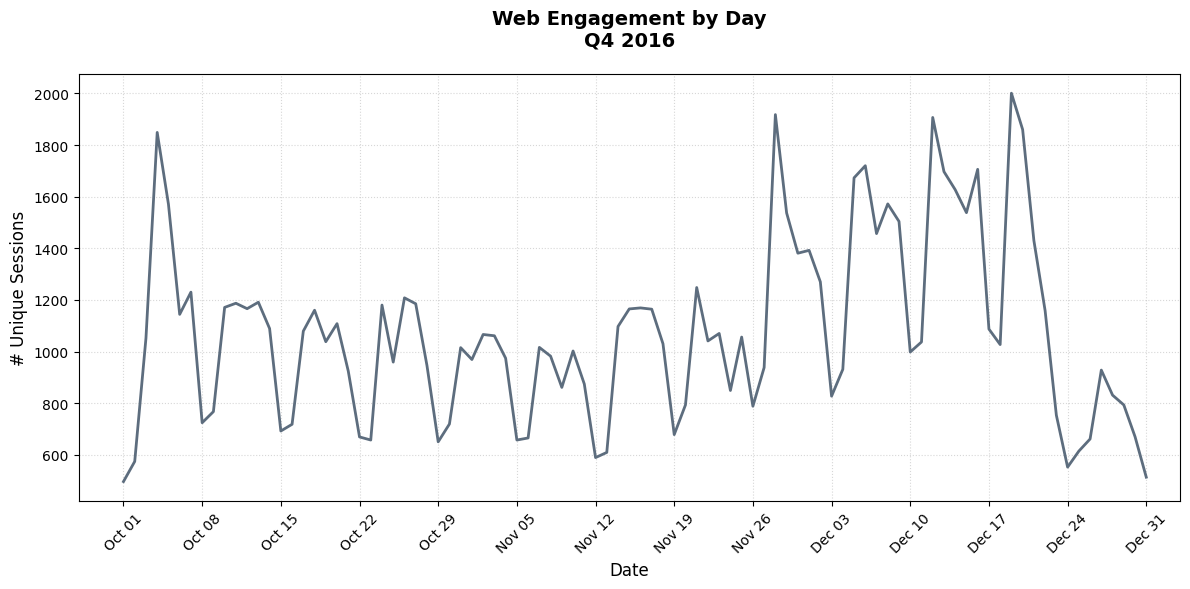

In [11]:
import matplotlib.dates as mdates

# 1. Ensure date format
sessions_day['day'] = pd.to_datetime(sessions_day['day'])

# 2. Setup the plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=sessions_day, x='day', y='n_unique_sessions', color='#5D6D7E', linewidth=2)

ax = plt.gca()

# 1. Set the canvas limits (Padding)
# 2. I extend the view to Sept 27 - Jan 03 so the data doesn't touch the frame borders
start_pad = pd.Timestamp('2016-09-27')
end_pad = pd.Timestamp('2017-01-03')
ax.set_xlim(start_pad, end_pad)

# 3. Force ticks to start on Oct 1 and end on Dec 31
# Since 2016-10-01 is a Saturday and 2016-12-31 is a Saturday,
# a weekly frequency (7 Days) hits both dates perfectly.
custom_ticks = pd.date_range(start='2016-10-01', end='2016-12-31', freq='7D')
ax.set_xticks(custom_ticks)

# 4. Format the labels
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

# 5. Chart Visual Elements
plt.title('Web Engagement by Day\nQ4 2016', fontsize=14, fontweight='bold', pad=20)
plt.ylabel('# Unique Sessions', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.xticks(rotation=45)
plt.grid(visible=True, linestyle='dotted', alpha=0.5)

plt.tight_layout()
plt.show()

### Web Engagement by days of the week


It can be seen that **weekends** are the days with **less engagement**.

In [12]:
sessions_dow = _dntk.execute_sql(
  'SELECT\n    STRFTIME(start_date, \'%A\') AS day_of_week, -- STRFTIME() converts the date format to a string\n    COUNT(DISTINCT session_id) AS n_unique_sessions\nFROM data_cleaned\nGROUP BY 1, isodow(start_date)\nORDER BY isodow(start_date) -- isodow() returns the # of dow with monday being day one',
  'SQL_DEEPNOTE_DATAFRAME_SQL',
  audit_sql_comment='',
  sql_cache_mode='cache_disabled',
  return_variable_type='dataframe'
)
sessions_dow

,day_of_week,n_unique_sessions
0,Monday,17018
1,Tuesday,17054
2,Wednesday,15875
3,Thursday,15157
4,Friday,14026
5,Saturday,9920
6,Sunday,10049


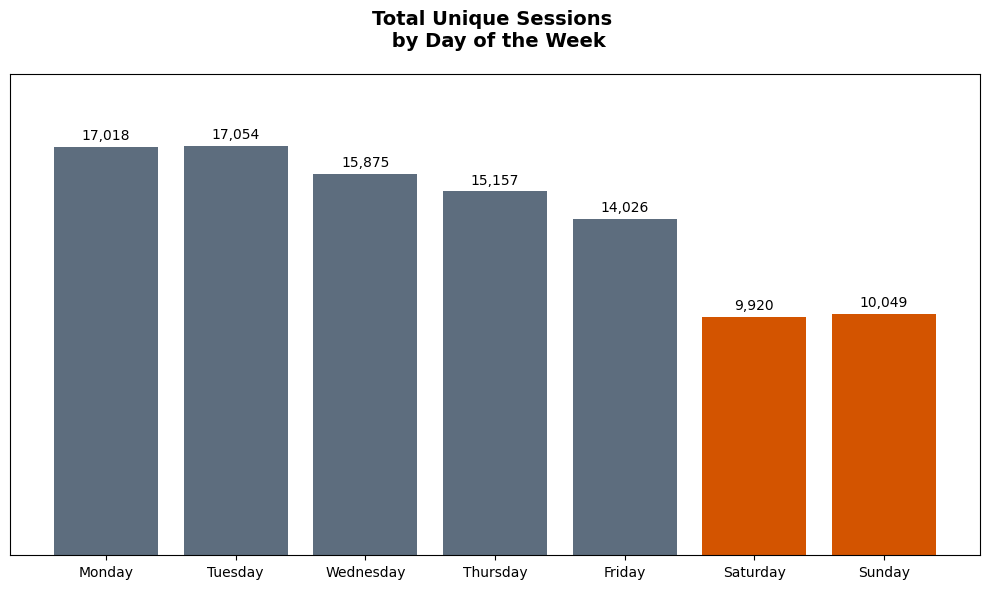

In [13]:
# Setup the plot
plt.figure(figsize=(10, 6))

# Define order for days of week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Define colors to differentiate weekdays/weekend
colors = ['#D35400' if day in ['Saturday', 'Sunday'] else '#5D6D7E' for day in day_order]

# Create the Bar Chart
plt.bar(sessions_dow['day_of_week'], sessions_dow['n_unique_sessions'], color=colors)
# Get the Axes object
ax = plt.gca()


# Y-AXIS CONFIGURATION ---------------------------------------------------------

# Remove the Y-axis title
ax.set_ylabel('')

# Force the left black line to appear
ax.spines['left'].set_visible(True)                  

# Remove the Y-axis tick marks AND the numeric label values
ax.tick_params(axis='y', left=False, labelleft=False) 

# Add Data Labels
for bar in ax.patches:
    height = bar.get_height()
    label = f'{height:,.0f}' 
    
    ax.text(
        bar.get_x() + bar.get_width() / 2, 
        height + 200, 
        label,
        ha='center', 
        va='bottom',
        fontsize=10
    )
#--------------------------------------------------------------------------------

# Labels and Style
plt.title('Total Unique Sessions \n by Day of the Week', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('') 
plt.ylim(0, max(sessions_dow['n_unique_sessions']) + 3000) 
plt.tight_layout()
plt.show()

## Web Engamenent and Monetization

In this part of the analysis I will analyze the follwing KPIs to understand the user behavior and how it relates to monetization. 

> - Number of sessions 
> - Percentage of sessions 
> - Revenue 
> - Percentage of Revenue
Each KPIs will be analyzed by the following dimensions:

> - Day of the week
> - Device category
> - Country and Region



In [14]:
data_conversions = _dntk.execute_sql(
  'WITH data_conversions AS (\n    SELECT \n        session_id,\n        fullvisitorid,\n        visitid,\n        newvisits,\n        bounces,\n        channelGrouping,\n        country,\n        region,\n        start_date,\n        deviceCategory,\n        transactions,\n        transactionrevenue,\n        pageviews,\n        timeonsite,\n        timeonscreen,\n        CASE WHEN transactions >= 1 THEN 1 ELSE 0\n            END AS hasConverted\n    FROM data_cleaned\n)\n\nSELECT *\nFROM data_conversions',
  'SQL_DEEPNOTE_DATAFRAME_SQL',
  audit_sql_comment='',
  sql_cache_mode='cache_disabled',
  return_variable_type='dataframe'
)
data_conversions

,session_id,fullvisitorid,visitid,newvisits,bounces,channelGrouping,country,region,start_date,deviceCategory,transactions,transactionrevenue,pageviews,timeonsite,timeonscreen,hasConverted
0,23962618373677556221476002073,2396261837367755622,1476002073,0,0,Organic Search,United States,None,2016-10-09 01:34:33+00:00,desktop,0,0.00,0.0,0.0,0,0
1,92201882287009663161476783975,9220188228700966316,1476783975,0,0,Organic Search,United States,None,2016-10-18 02:46:15+00:00,desktop,0,0.00,0.0,9.0,0,0
2,56177701532453033091476907903,5617770153245303309,1476907903,0,0,Referral,United States,California,2016-10-19 13:11:43+00:00,desktop,0,0.00,0.0,399.0,0,0
3,11485237893747504921476542990,1148523789374750492,1476542990,0,1,Affiliates,United States,None,2016-10-15 07:49:50+00:00,mobile,0,0.00,1.0,0.0,0,0
4,47387249991085221541477262558,4738724999108522154,1477262558,1,1,Direct,United States,California,2016-10-23 15:42:38+00:00,mobile,0,0.00,1.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99094,0819856860305326191481306198,081985686030532619,1481306198,0,0,Direct,United States,None,2016-12-09 09:56:38+00:00,desktop,1,346.62,143.0,2363.0,0,1
99095,50581969101599768701483021729,5058196910159976870,1483021729,1,0,Direct,United States,New York,2016-12-29 06:28:49+00:00,desktop,0,0.00,145.0,1935.0,0,0
99096,50372087880653398061481587574,5037208788065339806,1481587574,1,0,Referral,United States,California,2016-12-12 16:06:14+00:00,desktop,2,681.40,149.0,9275.0,0,1
99097,30474132027700641391482872974,3047413202770064139,1482872974,1,0,Social,United States,None,2016-12-27 13:09:34+00:00,desktop,0,0.00,190.0,3579.0,0,0


## Conversion by day of the week

In [15]:
_dntk.execute_sql(
  'SELECT\n    dayname(start_date) AS day_of_Week,\n    COUNT(DISTINCT session_id) AS n_sessions,\n    SUM(hasConverted) AS n_conversion,\n    ROUND(SUM(hasConverted)/ COUNT(DISTINCT session_id) * 100, 2) AS conversion_rate\nFROM data_conversions\nGROUP BY 1, isodow(start_date) -- use isodow() returns the # of dow. I can then sort the days of the week correctly\nORDER BY isodow(start_date)',
  'SQL_DEEPNOTE_DATAFRAME_SQL',
  audit_sql_comment='',
  sql_cache_mode='cache_disabled',
  return_variable_type='query_preview'
)

,day_of_Week,n_sessions,n_conversion,conversion_rate
0,Monday,17018,589.0,3.46
1,Tuesday,17054,507.0,2.97
2,Wednesday,15875,472.0,2.97
3,Thursday,15157,468.0,3.09
4,Friday,14026,457.0,3.26
5,Saturday,9920,231.0,2.33
6,Sunday,10049,296.0,2.95


## Conversion by device category

In [16]:
devices_data = _dntk.execute_sql(
  'SELECT\n    deviceCategory,\n    COUNT(session_id) AS n_sessions,\n    SUM(transactions) AS n_transactions,\n    SUM(transactionrevenue) AS revenue,\n    -- I don\'t round to avoid losing precision in subsequent analysis\n    COUNT(DISTINCT session_id) / SUM(COUNT(DISTINCT session_id)) OVER() * 100 AS session_percentage,\n    SUM(transactionrevenue) / SUM(SUM(transactionrevenue)) OVER () * 100 AS revenue_percentage,\n    SUM(hasConverted) / SUM(COUNT(session_id)) OVER() * 100 AS conversion_rate\n\nFROM data_conversions\nGROUP BY deviceCategory\nORDER BY 2 DESC\n',
  'SQL_DEEPNOTE_DATAFRAME_SQL',
  audit_sql_comment='',
  sql_cache_mode='cache_disabled',
  return_variable_type='dataframe'
)
devices_data

,deviceCategory,n_sessions,n_transactions,revenue,session_percentage,revenue_percentage,conversion_rate
0,desktop,71237,2857.0,379646.89,71.884681,94.443723,2.750785
1,mobile,24215,235.0,18957.89,24.435161,4.716103,0.235118
2,tablet,3647,61.0,3377.35,3.680158,0.840174,0.061555


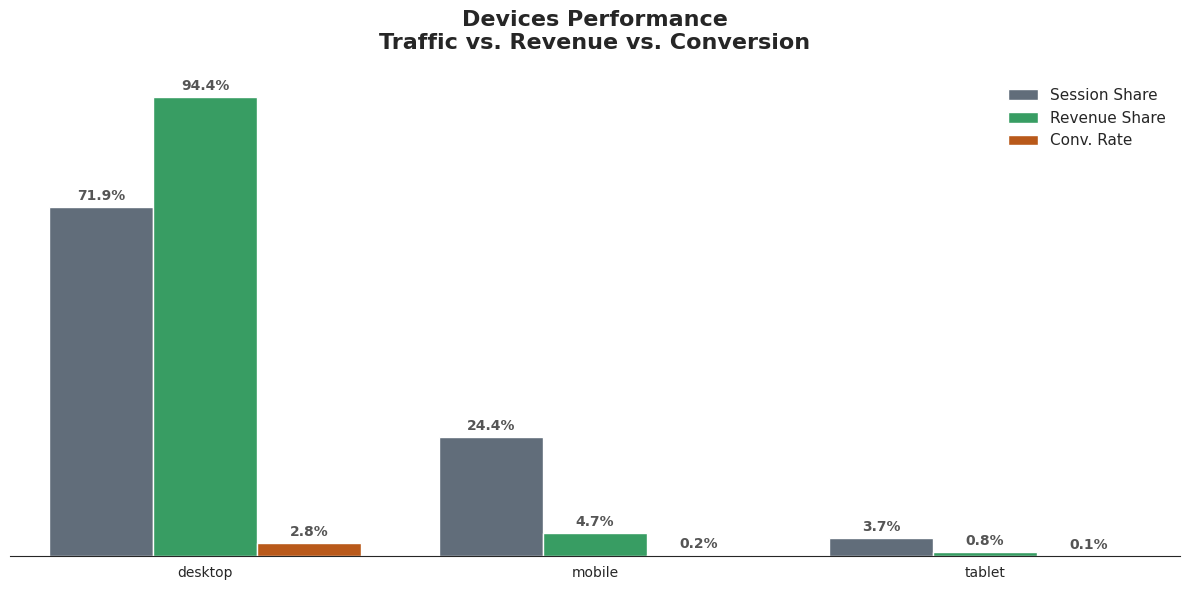

In [17]:
# 1. Prepare the dataframe
df_viz = pd.DataFrame(devices_data)

# 2. Transform for Plotting
df_melted = df_viz.melt(
    id_vars='deviceCategory', 
    value_vars=['session_percentage', 'revenue_percentage', 'conversion_rate'], 
    var_name='Metric', 
    value_name='Percentage'
)

# Rename legend
df_melted['Metric'] = df_melted['Metric'].replace({
    'session_percentage': 'Session Share',
    'revenue_percentage': 'Revenue Share', 
    'conversion_rate': 'Conv. Rate'
})

# 3. Setup the Plot
plt.figure(figsize=(12, 6))
sns.set_style("white") 

# 4. Create Bar Chart
custom_palette = {
    'Session Share': '#5D6D7E',  # Slate Blue
    'Revenue Share': '#27AE60',  # Emerald Green
    'Conv. Rate':    '#D35400'   # Burnt Orange
} 

ax = sns.barplot(
    data=df_melted, 
    x='deviceCategory', 
    y='Percentage', 
    hue='Metric', 
    palette=custom_palette
)

# 5. Styling
ax.set_ylabel('')
ax.set_yticks([]) 
ax.spines['left'].set_visible(False)                  
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# 6. Data Labels
for container in ax.containers:
    ax.bar_label(
        container, 
        fmt='%.1f%%', 
        padding=3, 
        fontsize=10, 
        fontweight='bold', 
        color='#555555'
    )

# 7. Titles and Layout
plt.title('Devices Performance\nTraffic vs. Revenue vs. Conversion', fontsize=16, fontweight='bold', pad=18, loc='center')
plt.xlabel('')
plt.legend(frameon=False, loc='upper right', fontsize=11)

plt.tight_layout()
plt.show()

## Mobile Devices
### Conversion by Region 

In [18]:
_dntk.execute_sql(
  'SELECT\n    deviceCategory,\n    country,\n    region,\n    COUNT(DISTINCT session_id) AS n_sessions,\n    SUM(transactionrevenue) AS revenue,\n    COUNT(DISTINCT session_id) / SUM(COUNT(DISTINCT session_id)) OVER() * 100 AS session_percentage,\n    SUM(transactionrevenue) / SUM(SUM(transactionrevenue)) OVER() * 100 AS revenue_percentage,\n    SUM(hasConverted) / SUM(COUNT(session_id)) OVER() * 100 AS conversion_rate\nFROM data_conversions\nWHERE LOWER(deviceCategory) = \'mobile\'\nGROUP BY 1,2,3\nORDER BY 4 DESC,5 DESC,6 DESC,7 DESC\n',
  'SQL_DEEPNOTE_DATAFRAME_SQL',
  audit_sql_comment='',
  sql_cache_mode='cache_disabled',
  return_variable_type='query_preview'
)

,deviceCategory,country,region,n_sessions,revenue,session_percentage,revenue_percentage,conversion_rate
0,mobile,United States,None,14270,7062.12,58.930415,37.251614,0.549246
1,mobile,United States,California,4974,6712.06,20.540987,35.4051,0.194095
2,mobile,United States,New York,1320,566.69,5.451167,2.989204,0.041297
3,mobile,United States,Texas,995,177.89,4.109023,0.938343,0.024778
4,mobile,United States,Illinois,766,1673.27,3.163329,8.826246,0.053686
5,mobile,United States,Washington,334,2124.12,1.37931,11.204411,0.037167
6,mobile,United States,Georgia,327,233.41,1.350403,1.231202,0.016519
7,mobile,United States,District of Columbia,308,20.99,1.271939,0.110719,0.00413
8,mobile,United States,Massachusetts,147,35.98,0.607062,0.189789,0.008259
9,mobile,United States,Michigan,123,0.0,0.50795,0.0,0.0


### Country/Region Minor Mismatch

As I was working with the dataset I found one record with mismatched Country/Region labeling.
One session was recorded with the `country = United States` and `region = Abu Dhabi`, after a quick research there seem to be no city or region called `Abu Dhabi` in the United States.
Given the dataset size (99k+ rows), this single mismatch is statistically insignificant (<0.001%) and so I decided to remove it.

In [19]:
query_10 = _dntk.execute_sql(
  '-- Noticed a small inregrity issue\nSELECT region, country\nFROM data_cleaned\nWHERE UPPER(country) LIKE \'UNITED%\' AND UPPER(region) LIKE \'ABU%\'',
  'SQL_DEEPNOTE_DATAFRAME_SQL',
  audit_sql_comment='',
  sql_cache_mode='cache_disabled',
  return_variable_type='query_preview'
)
query_10

,region,country
0,Abu Dhabi,United States


In [20]:
unique_region_country = data_cleaned.drop_duplicates(subset=['region', 'country'])[['country', 'region']].values.tolist()

# retrieve the index number of the the record 
i = data_cleaned[data_cleaned['region'] == 'Abu Dhabi'].index[0]

# drop that one record
data_cleaned = data_cleaned.drop(labels=i, axis=0)



## Website Retention

- New Visitors vs Returning Visitors


In [21]:
df_11 = _dntk.execute_sql(
  'SELECT\n    CASE WHEN newvisits = 1 THEN \'New Visitor\' ELSE \'Returning Visitor\' END AS visitor_type,\n    COUNT(DISTINCT fullvisitorid) AS n_visitors,\n    COUNT(DISTINCT fullvisitorid) / SUM(COUNT(DISTINCT fullvisitorid)) OVER() * 100 AS visitor_pct\nFROM data_conversions\nGROUP BY 1',
  'SQL_DEEPNOTE_DATAFRAME_SQL',
  audit_sql_comment='',
  sql_cache_mode='cache_disabled',
  return_variable_type='dataframe'
)
df_11

,visitor_type,n_visitors,visitor_pct
0,Returning Visitor,17192,21.047992
1,New Visitor,64488,78.952008


## Website Acquisition and Monetization by Channel

> **Note**: A session is classified as bounced if it meets all three of the following criteria:
> - The session lasted less than 10 seconds.
> - The session had zero conversion events.
> - The user viewed fewer than 2 pages or screens.

Google Analytics provides us a `bounces` field that flags whether a session is considered bounced or not. 

In [22]:
channels_data = _dntk.execute_sql(
  'SELECT\n    channelGrouping AS channel,\n    SUM(bounces) AS bounced_total,\n    SUM(bounces) / COUNT(session_id) * 100 AS bounced_rate,\n    SUM(pageviews) / COUNT(session_id) AS avg_page_per_session,\n    SUM(timeonsite) / COUNT(session_id) AS avg_time_per_session,\n    SUM(CASE WHEN transactions = 1 THEN 1 ELSE 0 END) AS n_conversions,\n    SUM(CASE WHEN transactions = 1 THEN 1 ELSE 0 END) / COUNT(session_id) * 100 AS conversion_rate,\n    SUM(transactionrevenue) AS revenue,\n    SUM(transactionrevenue) / SUM(SUM(transactionrevenue)) OVER() * 100 AS revenue_percentage\nFROM data_conversions\nGROUP BY 1\nORDER BY 4 DESC, 5 DESC, 6 DESC',
  'SQL_DEEPNOTE_DATAFRAME_SQL',
  audit_sql_comment='',
  sql_cache_mode='cache_disabled',
  return_variable_type='query_preview'
)
channels_data

,channel,bounced_total,bounced_rate,avg_page_per_session,avg_time_per_session,n_conversions,conversion_rate,revenue,revenue_percentage
0,Referral,3277.0,15.07429,8.158609,257.640922,1382.0,6.357238,177011.16,44.034584
1,Paid Search,2307.0,33.733002,5.78608,176.582688,154.0,2.251791,13969.4,3.47513
2,Organic Search,12717.0,31.84345,5.738381,190.494466,850.0,2.128405,80724.41,20.081592
3,Display,688.0,34.314214,5.251372,170.221446,34.0,1.695761,4728.45,1.176284
4,Direct,9584.0,46.241436,4.742401,164.312844,497.0,2.397954,124718.34,31.025842
5,Affiliates,395.0,50.706033,2.661104,125.979461,1.0,0.12837,12.99,0.003231
6,Social,3235.0,45.724382,2.627562,89.473781,12.0,0.169611,817.38,0.203337


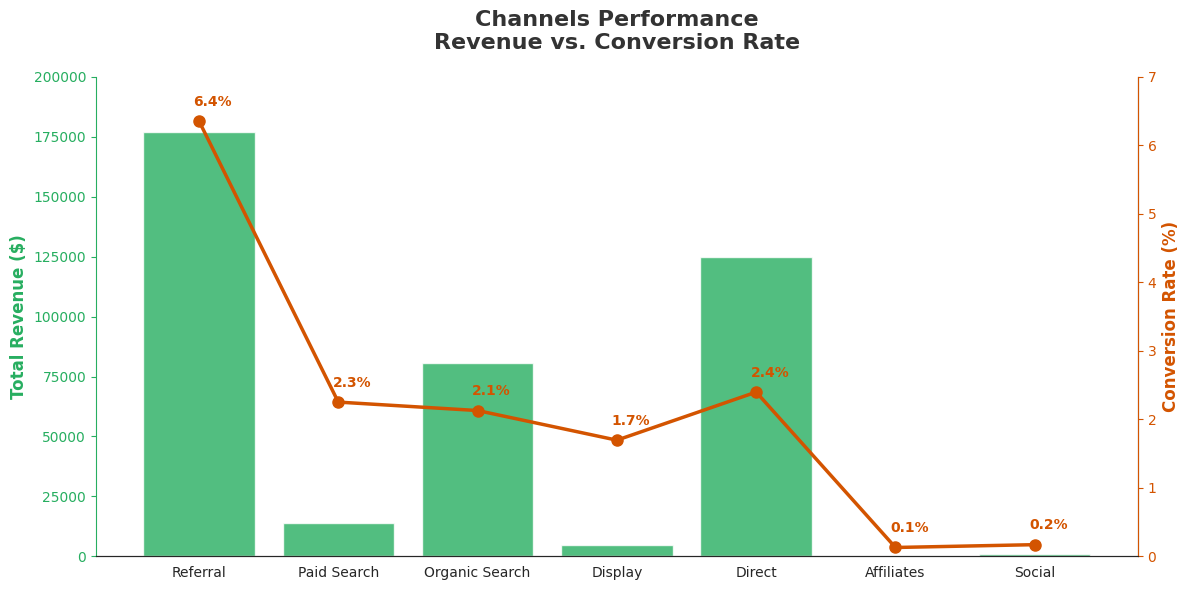

In [23]:
df = channels_data # for simplicity I will call it df

# 2. Setup seaborn
fig, ax1 = plt.subplots(figsize=(12, 6))
sns.set_style("white")

# --- PLOT 1: REVENUE (Bars) ---
# Using the "Money" Color (Emerald Green)
# alpha=0.8 makes it slightly softer so the line stands out
ax1.bar(df['channel'], df['revenue'], color='#27AE60', alpha=0.8, label='Revenue')

# Style Axis 1
ax1.set_ylabel('Total Revenue ($)', fontsize=12, fontweight='bold', color='#27AE60')
ax1.tick_params(axis='y', colors='#27AE60') # Color the ticks to match
ax1.set_ylim(0, 200000)
ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_color('#27AE60') # Color the spine line

# --- PLOT 2: CONVERSION RATE (Line) ---
ax2 = ax1.twinx() # Create shared axis

# marker='o' adds the dots, linewidth=2.5 makes it thick
ax2.plot(df['channel'], df['conversion_rate'], color='#D35400', marker='o', linewidth=2.5, markersize=8, label='Conversion Rate')

# Style Axis 2
ax2.set_ylabel('Conversion Rate (%)', fontsize=12, fontweight='bold', color='#D35400')
ax2.tick_params(axis='y', colors='#D35400') # Color the ticks to match
ax2.set_ylim(0, 7)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_color('#D35400') # Color the spine line
ax2.spines['left'].set_visible(False)

# 3. Add Labels (Optional but recommended)
# Labeling the Line Points
for x, y in zip(range(len(df)), df['conversion_rate']):
    ax2.annotate(f'{y:.1f}%', (x+0.1, y+0.02), textcoords="offset points", xytext=(0,10), ha='center', 
                 color='#D35400', fontweight='bold')

# 4. Final Title
plt.title('Channels Performance\nRevenue vs. Conversion Rate', fontsize=16, fontweight='bold', pad=20, color='#333333')

plt.tight_layout()
plt.show()

# Executive Summary & Recommendations

## 1. Mobile Device Gap (UX Priority)
* **Observation:** Mobile users account for **24%** of our total traffic but generate only **4.7%** of our revenue.
* **Insight:** The conversion rate on mobile is drastically lower than desktop. This strongly suggests a friction point in the mobile checkout process or flow.
* **Recommendation:** Prioritize a UX/UI audit of the mobile experience to unlock this revenue potential.

## 2. Marketing Efficiency (Channel Strategy)
* **Observation:** **Referral** traffic drives the highest conversion efficiency (**6.4%**), significantly outperforming Paid Search (**2.3%**) and Social (**0.2%**).
* **Insight:** Social media brings "window shoppers," while Referrals bring "buyers."
* **Recommendation:** Reallocate budget from underperforming Social campaigns to boost high-converting Referral partnerships.

## 3. Data Integrity (Reporting Accuracy)
* **Observation:** Raw data contained duplicate sessions caused by UTC midnight splits.
* **Action:** Implemented a deduplication pipeline correcting the daily unique visitor count.
* **Result:** Reporting is now **100% accurate**, preventing inflated traffic metrics in future reports.